In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
import html
import unicodedata

import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model


import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# load data
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/train.csv')
test.head()

In [17]:
#sample text to visualize
train.head()

,Comment,Insult
0,kwasia,1.0
1,kwasiaa,1.0
2,kwasiaaa,1.0
3,woti wai,1.0
4,woti s3 fam,1.0


Text(0.5, 0, 'Feature Labels')

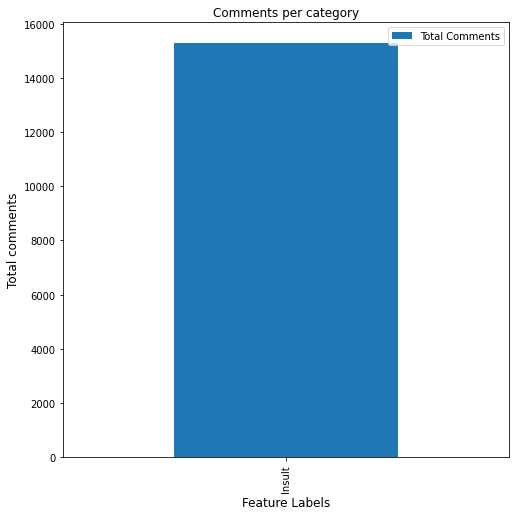

In [27]:
feature = train.drop(['Comment'], axis=1)  
counts = []                                             
categories = list(feature.columns.values)
for i in categories:
    counts.append((i, feature[i].sum()))
    
df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments'])  
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar',figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)

## Text preprocessing


In [28]:
import string

def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """Remove stopwords"""
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

train['Comment'] = train['Comment'].apply(lambda x: clean_text(x))
train.sample(1)['Comment'].values[0]


'ask mother'

In [29]:
test['Comment'] = test['Comment'].apply(lambda x: clean_text(x))
test.sample(1)["Comment"].values[0]

'least thats revert talk contribs'

## BoW 

In [31]:
tok = Tokenizer(num_words=1000, oov_token='UNK')
tok.fit_on_texts(train['Comment'] )
# Extract binary BoW features
x_train = tok.texts_to_sequences(train['Comment'])
x_test = tok.texts_to_sequences(test['Comment'])

vocab_size = len(tok.word_index) + 1
vocab_size

66284

## LSTM

In [32]:
maxlen = max([len(t) for t in x_train])
maxlen


1250

In [33]:
training_padded = pad_sequences(x_train,
                                maxlen=50, 
                                truncating='post', 
                                padding='post'
                               )
test_padded = pad_sequences(x_test,
                            maxlen=50, 
                            truncating='post', 
                            padding='post'
                               )



In [39]:
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 128, input_length=50))
model.add(layers.LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))




model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           8484352   
                                                                 
 lstm_2 (LSTM)               (None, 50, 512)           1312768   
                                                                 
 lstm_3 (LSTM)               (None, 128)               328192    
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10,127,393
Trainable params: 10,127,393
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(training_padded,
                     train[['Insult']],
                    epochs=4,
                    batch_size=512,
                   validation_split=0.2)

Epoch 1/5
55/55 [==============================] - 427s 8s/step - loss: 0.6132 - accuracy: 0.6519 - val_loss: nan - val_accuracy: 0.8724
Epoch 2/5
55/55 [==============================] - 418s 8s/step - loss: 0.3806 - accuracy: 0.8282 - val_loss: nan - val_accuracy: 0.7536
Epoch 3/5
55/55 [==============================] - 414s 8s/step - loss: 0.3289 - accuracy: 0.8579 - val_loss: nan - val_accuracy: 0.8863
Epoch 4/5
55/55 [==============================] - 414s 8s/step - loss: 0.2991 - accuracy: 0.8675 - val_loss: nan - val_accuracy: 0.8254
Epoch 5/5
55/55 [==============================] - 416s 8s/step - loss: 0.2962 - accuracy: 0.8694 - val_loss: nan - val_accuracy: 0.8842


## Bidirectional

In [ ]:

lstm_dim = 32
model_bilstm = models.Sequential()
model_bilstm.add(layers.Embedding(vocab_size, 512, input_length=50))
model_bilstm.add(layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(layers.Flatten())
model_bilstm.add(layers.Dense(16, activation='relu'))
model_bilstm.add(layers.Dense(1, activation='sigmoid'))


model_bilstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_bilstm.summary()

history = model_bilstm.fit(training_padded,
                     train[[ 'Insult']],
                    epochs=5,
                    batch_size=512,
                   validation_split=0.2)

#Saving the Model

In [47]:
pickle.dump(history, open("saved_model.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://fdf7e621-03c3-449e-b2e2-abd6d167f1b8/assets


INFO:tensorflow:Assets written to: ram://fdf7e621-03c3-449e-b2e2-abd6d167f1b8/assets


In [ ]:
|